##  Volume of water and tracer mass upwelled onto the shelf

In [1]:
#import gsw as sw # Gibbs seawater package

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline

from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys

import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
sns.set_context('paper')
sns.set_style('white')

In [3]:
def plotCanyonPos(ax,UpX,DnX):
    ax.axvline(UpX,color='0.70',linestyle='--')
    ax.axvline(DnX,color='0.70',linestyle='--')
def HCW_Tracer_AlongShelf(Tr,Tr1,MaskC,nzlim,rA,hFacC,drF,yin,zfin,xi,yi):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
                                                
    -----------------------------------------------------------------------------------------------------------------------
    '''
    maskExp = mpt.maskExpand(MaskC,Tr)

    TrMask=np.ma.array(Tr,mask=maskExp)   
    Tr1Mask=np.ma.array(Tr1,mask=maskExp)   
    
    #trlim1 = TrMask[0,nzlim,yi,xi]
    #trlim2 = TrMask[0,nzlim+1,yi,xi]
    #trlim = (trlim1+trlim2)/2
    trlim = 7.21757 # this should be trlim1 but the code has memory errors so I'm trying to make arrays smaller
    print('tracer limit concentration is: ',trlim)
    
    
    # mask cells with tracer concentration < trlim on shelf
    HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
    HighConc_Mask = HighConc_Masked.mask
    
    #Get volume of water of cells with relatively high concentration
    rA_exp = np.expand_dims(rA[yin:,:],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
    ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
     
    HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
    VolWaterHighConc =np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    
     #Get total mass of tracer on shelf
    Total_Tracer = np.ma.sum(np.ma.sum(ShelfVolume_exp*Tr1Mask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1)
    # 1 m^3 = 1000 l
    
    return (VolWaterHighConc, Total_Tracer)

In [4]:
# Constants and scales
L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh=97.5 # head depth
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,L=6400.0,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*L))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)



In [5]:
#Exp
CGrid = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc' 
CGridOut = Dataset(CGrid)

CGridNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc' 
CGridNoCOut = Dataset(CGridNoC)

State = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
StateNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/stateGlob.nc' 

Ptracers = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc' 
PtracersOut = Dataset(Ptracers)

Ptracers3D = '/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run27/ptracersGlob.nc' 
PtracersOut3D = Dataset(Ptracers3D)

PtracersHD = '/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run16/ptracersGlob.nc' 
PtracersOutHD = Dataset(PtracersHD)

PtracersNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc' 
PtracersOutNoC = Dataset(PtracersNoC)


In [6]:
# General input

nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 

rc = CGridNoCOut.variables['RC']
dxf = CGridNoCOut.variables['dxF']
xc = rout.getField(CGridNoC, 'XC') # x coords tracer cells
yc = rout.getField(CGridNoC, 'YC') # y coords tracer cells

rA = rout.getField(CGridNoC, 'rA') 

drF = CGridNoCOut.variables['drF'] # vertical distance between faces
drC = CGridNoCOut.variables['drC'] # vertical distance between centers

hFacC = Dataset(CGridNoC).variables['HFacC'][:31,227:,:] 
mask_NoC = rout.getMask(CGridNoC, 'HFacC')[:31,227:,:]

times = np.arange(0,nt,1)

In [7]:
Tr1 = Dataset(Ptracers).variables['Tr1'][:,:31,227:,:]
Tr1NoC = Dataset(PtracersNoC).variables['Tr1'][:,:31,227:,:]
     
Tr2 = Dataset(Ptracers).variables['Tr2'][:,:31,227:,:]
Tr2NoC = Dataset(PtracersNoC).variables['Tr2'][:,:31,227:,:]

Tr13D = Dataset(Ptracers3D).variables['Tr1'][:,:31,227:,:]
Tr23D = Dataset(Ptracers3D).variables['Tr2'][:,:31,227:,:]

Tr1HD = Dataset(PtracersHD).variables['Tr1'][:,:31,227:,:]
Tr2HD = Dataset(PtracersHD).variables['Tr2'][:,:31,227:,:]


In [8]:
HCW,TrMass = HCW_Tracer_AlongShelf(Tr2,Tr1,mask_NoC,29,rA[227:,:],hFacC,drF[:31],0,30,180,50)

HCWNoC,TrMassNoc = HCW_Tracer_AlongShelf(Tr2NoC,Tr1NoC,mask_NoC,29,rA[227:,:],hFacC,drF[:31],0,30,180,50)

HCW3D,TrMass3D = HCW_Tracer_AlongShelf(Tr23D,Tr13D,mask_NoC,29,rA[227:,:],hFacC,drF[:31],0,30,180,50)
HCWHD,TrMassHD = HCW_Tracer_AlongShelf(Tr2HD,Tr1HD,mask_NoC,29,rA[227:,:],hFacC,drF[:31],0,30,180,50)


tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757


In [9]:
import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [10]:
ii=0
for rec in records:
    print(ii,rec.name)
    ii=ii+1
    
select_rec=[0,38,49,33,31,5,10,19]

line_sty = ['-','-','-','--',':','-','-','-']
line_w = [2,1,1,1,1,1,1,1]

0 CNTDIFF_run38
1 CNTDIFF_run37
2 CNTDIFF_run36
3 CNTDIFF_run45
4 CNTDIFF_run73
5 CNTDIFF_run75
6 CNTDIFF_run79
7 CNTDIFF_run67
8 CNTDIFF_run51
9 CNTDIFF_run69
10 CNTDIFF_run71
11 3DVISC_run01
12 3DVISC_run02
13 3DVISC_run04
14 3DVISC_run03
15 3DVISC_run05
16 3DVISC_run06
17 LOWER_BF_run01
18 LOW_BF_run01
19 LOWEST_BF_run01
20 LOWEST_BF_run03
21 LOWEST_BF_run05
22 LOWEST_BF_run07
23 LOWEST_BF_run11
24 3DVISC_REALISTIC_run01
25 3DVISC_REALISTIC_run02
26 3DVISC_REALISTIC_run03
27 3DVISC_REALISTIC_run05
28 3DVISC_REALISTIC_run06
29 3DVISC_REALISTIC_run07
30 3DVISC_REALISTIC_run08
31 3DVISC_REALISTIC_run09
32 3DVISC_REALISTIC_run10
33 3DVISC_REALISTIC_run11
34 3DVISC_REALISTIC_run12
35 3DVISC_REALISTIC_run13
36 3DVISC_REALISTIC_run14
37 3DVISC_REALISTIC_run15
38 3DVISC_REALISTIC_run16
39 3DVISC_REALISTIC_run17
40 3DVISC_REALISTIC_run18
41 3DVISC_REALISTIC_run19
42 3DVISC_REALISTIC_run20
43 3DVISC_REALISTIC_run21
44 3DVISC_REALISTIC_run22
45 3DVISC_REALISTIC_run23
46 3DVISC_REALISTIC_run24


/data/kramosmu/results/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun38.csv /data/kramosmu/results/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun42.csv
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/HCW_TrMass_3DVISC_REALISTICrun16.csv /data/kramosmu/results/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun42.csv
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/HCW_TrMass_3DVISC_REALISTICrun27.csv /data/kramosmu/results/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun42.csv
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/HCW_TrMass_3DVISC_REALISTICrun11.csv /data/kramosmu/results/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun42.csv
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/HCW_TrMass_3DVISC_REALISTICrun09.csv /data/kramosmu/results/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun42.csv
/data/kramosmu/results/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun75.csv /data/kramosmu/results/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun76.csv
/dat

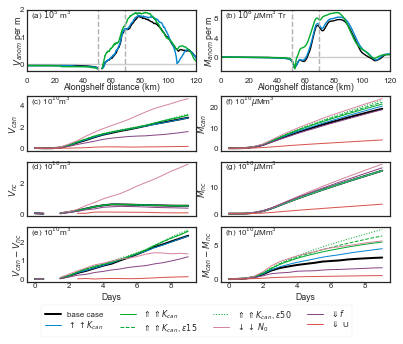

In [14]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (6.5,5)) # 190mm = 7.5in, 115cm = 4.52in

gs = gspec.GridSpec(2, 2,wspace=0.15,height_ratios=[1,3])

gs1 = gspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1,0],hspace=0.2 )
gs2 = gspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1,1],hspace=0.2)

ax0 = plt.subplot(gs1[0,0],xticks=[])
ax1 = plt.subplot(gs1[1,0],xticks=[])
ax2 = plt.subplot(gs1[2,0])
ax3 = plt.subplot(gs2[0,0],xticks=[])
ax4 = plt.subplot(gs2[1,0],xticks=[])
ax5 = plt.subplot(gs2[2,0])
ax6 = plt.subplot(gs[0,0])
ax7 = plt.subplot(gs[0,1])

jj = 0

for ind in select_rec:
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    print(file, fileNoC)
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
    ax0.plot(np.arange(0,19,1)/2.0,
             (dfcan['HCW'][0:19])/1E10,
             line_sty[jj],color=sns.xkcd_rgb[records[ind].color],linewidth=line_w[jj])
    
    ax3.plot(np.arange(0,19,1)/2.0,
             (dfcan['TotTrMass'][0:19]-dfnoc['TotTrMass'][0])/1E10,
             line_sty[jj],
             color=sns.xkcd_rgb[records[ind].color],linewidth=line_w[jj])
    
    ax1.plot(np.arange(0,19,1)/2.0,
             (dfnoc['HCW'][0:19])/1E10,
             line_sty[jj],color=sns.xkcd_rgb[records[ind].color],linewidth=line_w[jj])
    
    ax4.plot(np.arange(0,19,1)/2.0,
             (dfnoc['TotTrMass'][0:19]-dfnoc['TotTrMass'][0])/1E10,
             line_sty[jj],
             color=sns.xkcd_rgb[records[ind].color2],linewidth=line_w[jj])
    
    ax2.plot(np.arange(0,19,1)/2.0,
             (dfcan['HCW'][0:19]-dfnoc['HCW'][0:19])/1E10,
             line_sty[jj],color=sns.xkcd_rgb[records[ind].color],linewidth=line_w[jj],
             label=records[ind].label2)
    
    ax5.plot(np.arange(0,19,1)/2.0,
             (dfcan['TotTrMass'][0:19]-dfnoc['TotTrMass'][0:19])/1E10,
             line_sty[jj],
             color=sns.xkcd_rgb[records[ind].color],linewidth=line_w[jj])
    jj=jj+1
    
# -  --------------------------------------------------------------------------------------------
ii = 7
ax6.axhline(0,color='0.8')
ax6.plot(xc[1,:]/1000,(HCW[ii,:]-HCWNoC[ii,:])/(100000*dxf[0,:]),
         color='black',linestyle='-')
ax6.plot(xc[1,:]/1000,(HCWHD[ii,:]-HCWNoC[ii,:])/(100000*dxf[0,:]),
         color=sns.xkcd_rgb['cerulean'],linestyle='-')
ax6.plot(xc[1,:]/1000,(HCW3D[ii,:]-HCWNoC[ii,:])/(100000*dxf[0,:]),
         color=sns.xkcd_rgb['kelly green'],linestyle='-')

ax7.axhline(0,color='0.8')
ax7.plot(xc[1,:]/1000,(TrMass[ii,:]-TrMassNoc[ii,:])/(100000000*dxf[0,:]),'-',
        color='black')
ax7.plot(xc[1,:]/1000,(TrMassHD[ii,:]-TrMassNoc[ii,:])/(100000000*dxf[0,:]),'-',
        color=sns.xkcd_rgb['cerulean'])
ax7.plot(xc[1,:]/1000,(TrMass3D[ii,:]-TrMassNoc[ii,:])/(100000000*dxf[0,:]),'-',
        color=sns.xkcd_rgb['kelly green'])

plotCanyonPos(ax6,xc[1,120]/1000,xc[1,240]/1000)
plotCanyonPos(ax7,xc[1,120]/1000,xc[1,240]/1000)


ax7.text(0.02,0.85,'(b) $10^8$ $\mu$Mm$^3$ Tr',transform=ax7.transAxes)    
ax6.text(0.02,0.85,'(a) $10^5$ m$^3$',transform=ax6.transAxes)

# ----------------------------------------------------------------------------------------------

ax0.text(0.02,0.85,'(c) 10$^{10}$m$^3$',transform=ax0.transAxes)
ax1.text(0.02,0.85,'(d) 10$^{10}$m$^3$',transform=ax1.transAxes)    
ax2.text(0.02,0.85,'(e) 10$^{10}$m$^3$',transform=ax2.transAxes)
ax3.text(0.02,0.85,'(f) 10$^{10}$$\mu$Mm$^3$',transform=ax3.transAxes)    
ax4.text(0.02,0.85,'(g) 10$^{10}$$\mu$Mm$^3$',transform=ax4.transAxes)
ax5.text(0.02,0.85,'(h) 10$^{10}$$\mu$Mm$^3$',transform=ax5.transAxes)    


ax0.set_ylabel('$V_{can}$ ',labelpad=0)
ax1.set_ylabel('$V_{nc}$ ',labelpad=0)
ax2.set_ylabel('$V_{can}-V_{nc}$ ',labelpad=-4)
ax2.set_xlabel('Days')

ax3.set_ylabel('$M_{can}$ ',labelpad=0)
ax4.set_ylabel('$M_{nc}$ ',labelpad=0)
ax5.set_ylabel('$M_{can}-M_{nc}$ ',labelpad=0)


ax5.set_xlabel('Days')

ax2.legend(bbox_to_anchor=(1.95,-0.35),ncol=4,labelspacing=0.1,frameon=True)

ax5.tick_params(axis='x', pad=1)
ax2.tick_params(axis='x', pad=1)
ax0.tick_params(axis='x', pad=0.1)
ax1.tick_params(axis='x', pad=0.1)

ax0.tick_params(axis='y', pad=3)
ax1.tick_params(axis='y', pad=3)
ax2.tick_params(axis='y', pad=3)
ax3.tick_params(axis='y', pad=3)
ax4.tick_params(axis='y', pad=3)
ax5.tick_params(axis='y', pad=3)
ax6.tick_params(axis='y', pad=3)
ax7.tick_params(axis='y', pad=3)

ax7.set_yticks([0,4,8])

ax6.set_xlabel('Alongshelf distance (km)',labelpad=-1)
ax7.set_xlabel('Alongshelf distance (km)',labelpad=-1)

ax6.set_ylabel('$V_{anom}$ per m',labelpad=-5)
ax7.set_ylabel('$M_{anom}$ per m ',labelpad=-2)
ax6.set_xlim(0,120)
ax7.set_xlim(0,120)
plt.savefig('figure4_v2.eps',format='eps',bbox_inches='tight')


In [15]:
print ("\t".join(['name&', 'Total HCW $10^{10}$ m$^3$&', 
                  'CanyonHCW (\%)&',  'TotTrMassHCW $10^{11}$ $\mu$Mm$^3$&', 'CanyonTrMassHCW (\%)&',
                  'TotalTrMass $10^{11}$ $\mu$Mm$^3$&', 'CanyonTotTrMass (\%)' ]))

select_rec = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
for ind in select_rec:
    
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' 
            %(records[ind].exp_code,
              records[ind].exp_code,
              records[ind].run_num))
    fileNoC = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' 
               %(recordsNoC[ind].exp_code,
                 recordsNoC[ind].exp_code,
                 recordsNoC[ind].run_num))
    
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
    print ("\t".join(['%s\t&%.2f\t&%.2f\t\t&%.2f\t\t&%.2f\t&%.2f\t\t&%.2f\t ' 
                      % (records[ind].name,
                         dfcan['HCW'][18]/1E10,
                         ((dfcan['HCW'][18]-dfnoc['HCW'][18])/dfcan['HCW'][18])*100,
                         (dfcan['TrMassHCW'][18])/1E11,
                         (((dfcan['TrMassHCW'][18])-
                           (dfnoc['TrMassHCW'][18]))/(dfcan['TrMassHCW'][18]))*100,
                         (dfcan['TotTrMass'][18])/1E11,
                         (((dfcan['TotTrMass'][18]-dfnoc['TotTrMass'][18]))/(dfcan['TotTrMass'][18]))*100)
                     ]))
                                                              
                                                                                                    



name&	Total HCW $10^{10}$ m$^3$&	CanyonHCW (\%)&	TotTrMassHCW $10^{11}$ $\mu$Mm$^3$&	CanyonTrMassHCW (\%)&	TotalTrMass $10^{11}$ $\mu$Mm$^3$&	CanyonTotTrMass (\%)
CNTDIFF_run38	&2.86	&81.61		&2.20		&82.57	&22.60		&1.40	 
CNTDIFF_run37	&2.80	&87.26		&2.05		&87.20	&22.63		&1.44	 
CNTDIFF_run36	&3.12	&63.77		&1.79		&58.68	&22.90		&1.66	 
CNTDIFF_run45	&2.08	&88.29		&1.57		&88.52	&22.31		&0.87	 
CNTDIFF_run73	&1.10	&77.74		&0.82		&77.91	&22.03		&0.46	 
CNTDIFF_run75	&4.63	&29.03		&3.69		&34.85	&23.09		&2.43	 


OSError: File b'/data/kramosmu/results/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun80.csv' does not exist